# Xây dựng mô hình học máy và so sánh hiệu quả giữa chúng

## Import thư viện cần dùng

In [39]:
# System library
import os
import time
import pickle
import warnings

# Statistics library
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, VotingClassifier,
                              BaggingClassifier, AdaBoostClassifier)

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

from sklearn.model_selection import (
    KFold,
    cross_validate,
    GridSearchCV
)

# Preprocessing
from sklearn.preprocessing import LabelEncoder

In [4]:
SEED = 42
RANDOM_STATE=123
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set(rc = {'figure.figsize':(15, 10)})
np.random.seed(SEED)

DATA_PATH = 'data/'
MODEL_PATH = 'model/'

## Phần II: Xây dựng mô hình

### Load Data from source

In [88]:
# Load processed data
X_train_cleaner_and_reduction_ = np.load(os.path.join(MODEL_PATH, 'X_train_cleaner_and_reduction_.npy'))
X_test_cleaner_and_reduction_ = np.load(os.path.join(MODEL_PATH, 'X_test_cleaner_and_reduction_.npy'))
y_train = np.load(os.path.join(MODEL_PATH, 'y_train.npy'))
y_test = np.load(os.path.join(MODEL_PATH, 'y_test.npy'))

le = pickle.load(open(os.path.join(MODEL_PATH, 'le_.pkl'), 'rb'))
le.classes_

array(['An sinh', 'Bất động sản', 'Giáo dục', 'Giải trí', 'Kinh doanh',
       'Pháp luật', 'Sức khỏe', 'Sức mạnh số', 'Thế giới', 'Thể thao',
       'Việc làm', 'Văn hóa', 'Xe ++', 'Xã hội'], dtype=object)

Chúng ta sẽ sử dụng tối ưu tham số để tìm ra mô hình tốt nhất và sau đó sẽ so sánh chúng với nhau

In [6]:
def evaluation_model(y_pred, y_test):
  acc = accuracy_score(y_test, y_pred)
  print("- Acc = {}".format(acc))
  print(classification_report(y_test, y_pred, target_names=le.classes_))
  return acc

In [7]:
def train_model(estimator, X_train, y_train, X_test, y_test):
  estimator_start = time.time()
  estimator.fit(X_train, y_train)
  print("Fit data completely ...")
  estimator_train_time = int(time.time() - estimator_start)
  y_pred = estimator.predict(X_test)

  estimator_acc = evaluation_model(y_pred, y_test)
  return estimator, estimator_acc, estimator_train_time


In [8]:
def create_params_based_on_estimator(estimator, X_train, y_train, scoring='accuracy', return_train_score=True, cv=None):
  params = dict (
      estimator=estimator,
      X=X_train,
      y=y_train,
      scoring=scoring,
      return_train_score=return_train_score,
      cv=cv,
      n_jobs=-1,
      verbose=3
  )
  return params

In [9]:
def get_loss_in_each_category(confustion_matrix):
  num_of_true_categories = np.diag(confustion_matrix)
  categories, cnt = np.unique(y_test, return_counts=True)
  categories = le.inverse_transform(categories)
  return pd.DataFrame({
      'categories': categories,
      'num_of_true_categories': num_of_true_categories,
      'num_of_false_categories': np.round(((cnt - num_of_true_categories) / cnt), 2),
      'total': cnt
  })

In [10]:
skf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

### 2.1 Single Classifier

#### SVM

In [ ]:

cv_params_svm = create_params_based_on_estimator(SVC(C=1.0, kernel='rbf', random_state=RANDOM_STATE),
                                                 X_train_cleaner_and_reduction_,
                                                 y_train,
                                                 cv=skf)

svm_cv = cross_validate(
    **cv_params_svm
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.7min finished


In [ ]:
svm_clf, svm_acc, svm_time = train_model(cv_params_svm['estimator'], X_train_cleaner_and_reduction_,
                                         y_train, X_test_cleaner_and_reduction_,
                                         y_test)

Fit data completely ...
- Acc = 0.9043274244004171
              precision    recall  f1-score   support

     An sinh       0.80      0.74      0.77       175
Bất động sản       0.93      0.93      0.93       361
    Giáo dục       0.92      0.95      0.93       416
    Giải trí       0.85      0.83      0.84       174
  Kinh doanh       0.86      0.90      0.88       312
   Pháp luật       0.90      0.97      0.93       120
    Sức khỏe       0.96      0.98      0.97       374
 Sức mạnh số       0.95      0.89      0.92       227
    Thế giới       0.90      0.84      0.87       207
    Thể thao       0.98      0.99      0.98       418
    Việc làm       0.82      0.81      0.81       213
     Văn hóa       0.90      0.88      0.89       307
       Xe ++       0.94      0.97      0.95       266
      Xã hội       0.82      0.82      0.82       266

    accuracy                           0.90      3836
   macro avg       0.89      0.89      0.89      3836
weighted avg       0.90      

[[129   1   5   0   0   0   3   1   1   0  20   1   2  12]
 [  1 335   0   1  10   1   0   2   2   0   1   0   2   6]
 [  3   0 395   3   1   0   0   0   2   0   6   6   0   0]
 [  0   1   3 144   2   1   2   1   0   3   0  15   0   2]
 [  1   8   1   3 281   1   3   2   3   0   3   1   2   3]
 [  0   2   0   0   0 116   0   0   1   0   0   0   0   1]
 [  0   0   2   1   4   0 365   1   0   0   1   0   0   0]
 [  0   0   7   0   5   2   2 201   3   1   0   2   2   2]
 [  4   3   7   1   6   5   1   0 174   0   2   2   1   1]
 [  0   0   0   5   0   1   0   0   0 412   0   0   0   0]
 [ 15   1   3   0   7   0   0   1   1   0 172   3   1   9]
 [  3   2   2  12   2   0   1   2   3   4   0 269   0   7]
 [  0   0   1   0   3   0   0   1   0   0   0   0 257   4]
 [  5   8   4   0   7   2   3   0   3   2   6   1   6 219]]


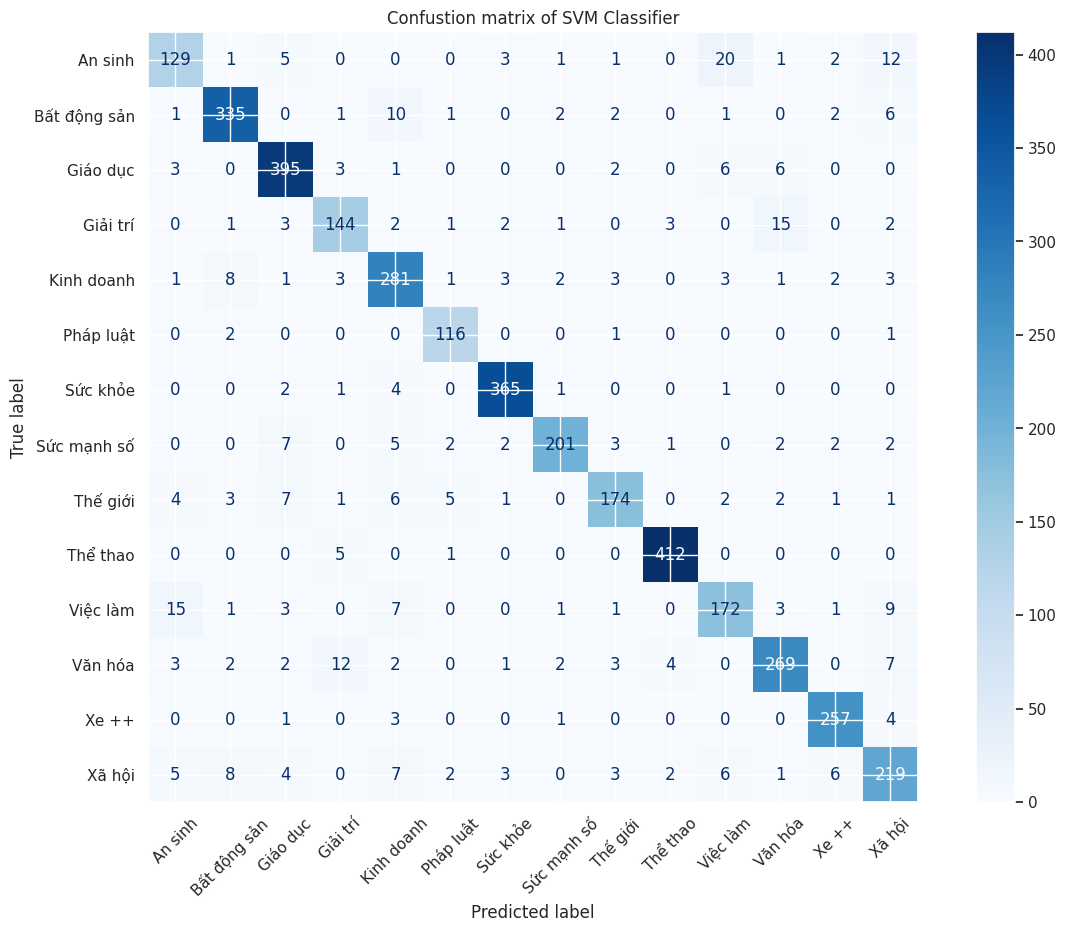

In [ ]:
svm_disp = ConfusionMatrixDisplay.from_estimator(
      svm_clf,
      X_test_cleaner_and_reduction_,
      y_test,
      display_labels=le.classes_,
      cmap=plt.cm.Blues,
)
svm_disp.ax_.set_title("Confustion matrix of SVM Classifier")
svm_disp.ax_.tick_params(axis='x', rotation=45)

print(svm_disp.confusion_matrix)

In [ ]:
get_loss_in_each_category(svm_disp.confusion_matrix)

,categories,num_of_true_categories,num_of_false_categories,total
0,An sinh,129,0.26,175
1,Bất động sản,335,0.07,361
2,Giáo dục,395,0.05,416
3,Giải trí,144,0.17,174
4,Kinh doanh,281,0.10,312
5,Pháp luật,116,0.03,120
6,Sức khỏe,365,0.02,374
7,Sức mạnh số,201,0.11,227
8,Thế giới,174,0.16,207
9,Thể thao,412,0.01,418


In [ ]:
with open(os.path.join(MODEL_PATH, 'svm_clf.pkl'), 'wb') as f:
  pickle.dump(svm_clf, f)

with open(os.path.join(MODEL_PATH, 'svm_cv.pkl'), 'wb') as f:
  pickle.dump(svm_cv, f)

In [92]:
#Load results
with open(os.path.join(MODEL_PATH, 'svm_clf.pkl'), 'rb') as f:
  svm_clf = pickle.load(f)

with open(os.path.join(MODEL_PATH, 'svm_cv.pkl'), 'rb') as f:
  svm_cv = pickle.load(f)

In [93]:
svm_cv

{'fit_time': array([41.86297297, 40.88232112, 43.32719898, 43.11398554, 21.84728074]),
 'score_time': array([20.48474741, 19.5894537 , 18.63891554, 18.20498323, 10.92738891]),
 'test_score': array([0.88715084, 0.90446927, 0.88659218, 0.9       , 0.8882057 ]),
 'train_score': array([0.97779019, 0.97429809, 0.97890767, 0.97639335, 0.975     ])}

#### SGD

In [ ]:
cv_params_sgd = create_params_based_on_estimator(SGDClassifier(loss='perceptron', max_iter=1000, eta0=0.001, early_stopping=True, n_jobs=-1, random_state=RANDOM_STATE),
                                                 X_train_cleaner_and_reduction_,
                                                 y_train,
                                                 cv=skf)

sgd_cv = cross_validate(
    **cv_params_sgd
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


In [ ]:
sgd_clf, sgd_acc, sgd_time = train_model(cv_params_sgd['estimator'], X_train_cleaner_and_reduction_,
                                         y_train, X_test_cleaner_and_reduction_,
                                         y_test)

Fit data completely ...
- Acc = 0.8852971845672576
              precision    recall  f1-score   support

     An sinh       0.83      0.66      0.73       175
Bất động sản       0.94      0.91      0.92       361
    Giáo dục       0.94      0.93      0.93       416
    Giải trí       0.91      0.59      0.71       174
  Kinh doanh       0.90      0.82      0.86       312
   Pháp luật       0.90      0.96      0.93       120
    Sức khỏe       0.94      0.98      0.96       374
 Sức mạnh số       0.86      0.92      0.89       227
    Thế giới       0.80      0.88      0.84       207
    Thể thao       0.95      0.99      0.97       418
    Việc làm       0.82      0.79      0.80       213
     Văn hóa       0.82      0.94      0.87       307
       Xe ++       0.85      0.98      0.91       266
      Xã hội       0.82      0.77      0.80       266

    accuracy                           0.89      3836
   macro avg       0.88      0.86      0.87      3836
weighted avg       0.89      

[[115   3   5   0   0   1   4   2   3   2  18   4   5  13]
 [  2 327   1   0   7   2   1   3   4   1   1   1   3   8]
 [  4   1 386   0   0   0   1   1   6   0   6  10   1   0]
 [  1   2   3 102   2   0   2   7   2   9   0  35   8   1]
 [  0   7   2   2 257   1   8   8   6   1   3   4   6   7]
 [  1   1   0   0   0 115   0   0   1   0   0   0   1   1]
 [  0   0   1   1   0   0 368   2   1   0   0   0   1   0]
 [  0   0   3   0   1   1   1 208   6   2   0   2   2   1]
 [  1   1   3   0   7   3   1   3 182   0   2   1   1   2]
 [  0   0   0   2   0   0   0   0   1 413   0   2   0   0]
 [ 11   0   2   0   7   0   1   3   6   0 168   4   3   8]
 [  1   0   0   5   0   0   0   3   3   3   0 288   2   2]
 [  0   0   1   0   1   0   0   1   1   0   0   0 261   1]
 [  3   6   5   0   4   5   5   1   5   2   8   2  14 206]]


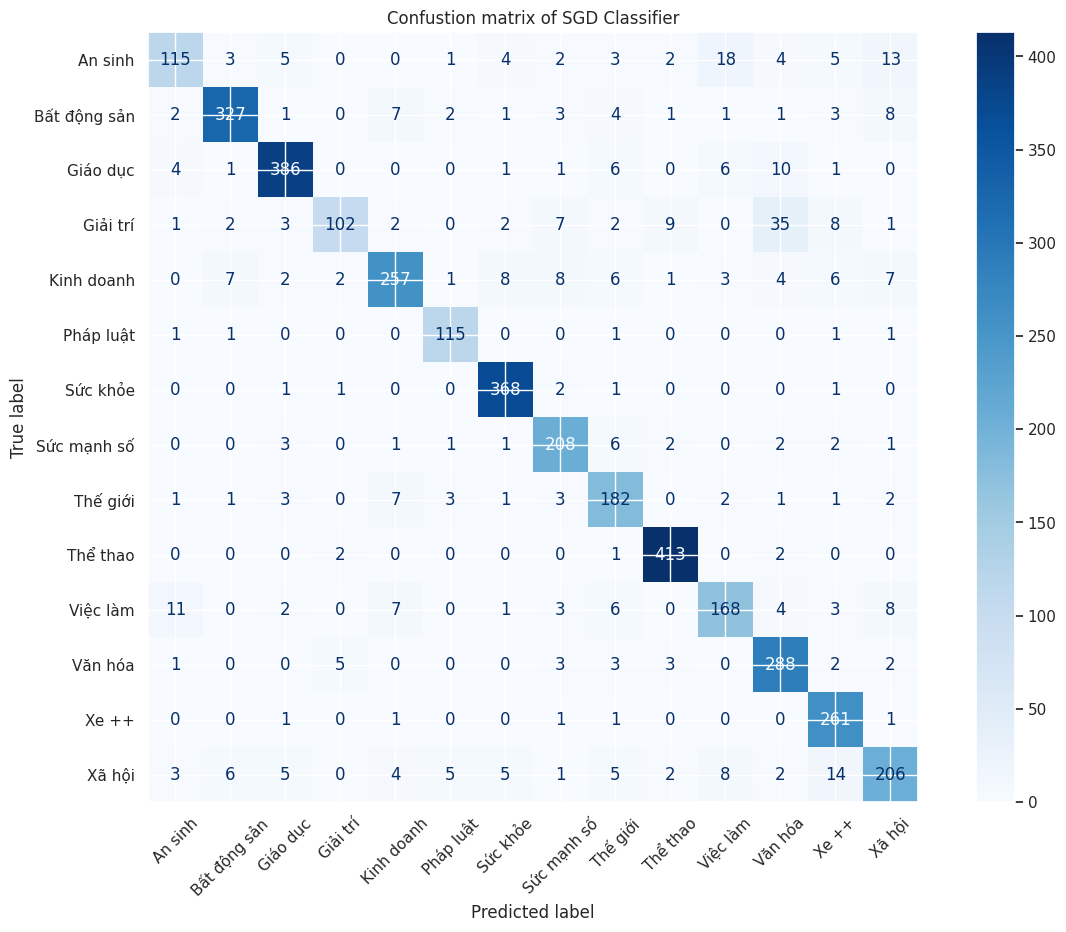

In [ ]:
sgd_disp = ConfusionMatrixDisplay.from_estimator(
      sgd_clf,
      X_test_cleaner_and_reduction_,
      y_test,
      display_labels=le.classes_,
      cmap=plt.cm.Blues,
)
sgd_disp.ax_.set_title("Confustion matrix of SGD Classifier")
sgd_disp.ax_.tick_params(axis='x', rotation=45)

print(sgd_disp.confusion_matrix)

In [ ]:
get_loss_in_each_category(sgd_disp.confusion_matrix)


,categories,num_of_true_categories,num_of_false_categories,total
0,An sinh,115,0.34,175
1,Bất động sản,327,0.09,361
2,Giáo dục,386,0.07,416
3,Giải trí,102,0.41,174
4,Kinh doanh,257,0.18,312
5,Pháp luật,115,0.04,120
6,Sức khỏe,368,0.02,374
7,Sức mạnh số,208,0.08,227
8,Thế giới,182,0.12,207
9,Thể thao,413,0.01,418


In [ ]:
with open(os.path.join(MODEL_PATH, 'sgd_clf.pkl'), 'wb') as f:
  pickle.dump(sgd_clf, f)

with open(os.path.join(MODEL_PATH, 'sgd_cv.pkl'), 'wb') as f:
  pickle.dump(sgd_cv, f)

In [ ]:
# Load results
with open(os.path.join(MODEL_PATH, 'sgd_clf.pkl'), 'rb') as f:
  sgd_clf = pickle.load(f)

with open(os.path.join(MODEL_PATH, 'sgd_cv.pkl'), 'rb') as f:
  sgd_cv = pickle.load(f)

In [ ]:
sgd_cv

{'fit_time': array([2.34408164, 2.06554031, 2.53790259, 2.47862411, 1.55650306]),
 'score_time': array([0.00929666, 0.01652098, 0.01256204, 0.0093832 , 0.00933647]),
 'test_score': array([0.8575419 , 0.87430168, 0.84860335, 0.8575419 , 0.85019564]),
 'train_score': array([0.95669786, 0.94817712, 0.94803744, 0.95390418, 0.93324022])}

#### GaussianNB

In [96]:
cv_params_gnb = create_params_based_on_estimator(GaussianNB(),
                                                 X_train_cleaner_and_reduction_,
                                                 y_train,
                                                 cv=skf)

gnb_cv = cross_validate(
    **cv_params_gnb
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.8s finished


In [97]:
gnb_clf, gnb_acc, gnb_time = train_model(cv_params_gnb['estimator'], X_train_cleaner_and_reduction_,
                                         y_train, X_test_cleaner_and_reduction_,
                                         y_test)

Fit data completely ...
- Acc = 0.7888425443169969
              precision    recall  f1-score   support

     An sinh       0.57      0.64      0.60       175
Bất động sản       0.81      0.87      0.84       361
    Giáo dục       0.88      0.89      0.88       416
    Giải trí       0.75      0.65      0.70       174
  Kinh doanh       0.58      0.75      0.65       312
   Pháp luật       0.80      0.93      0.86       120
    Sức khỏe       0.94      0.87      0.90       374
 Sức mạnh số       0.88      0.68      0.76       227
    Thế giới       0.68      0.77      0.72       207
    Thể thao       0.94      0.93      0.94       418
    Việc làm       0.65      0.58      0.61       213
     Văn hóa       0.73      0.76      0.74       307
       Xe ++       0.90      0.89      0.89       266
      Xã hội       0.78      0.58      0.66       266

    accuracy                           0.79      3836
   macro avg       0.78      0.77      0.77      3836
weighted avg       0.80      

[[112   3   3   1   7   4   3   0   4   1  15  12   1   9]
 [  0 313   0   2  17   1   2   1   8   0   6   5   1   5]
 [  9   2 369   2  11   0   0   2   1   1   9   9   0   1]
 [  3  10   3 113   8   1   2   1   2   6   0  24   0   1]
 [  8   9   4   4 234   2   2   9  13   0  15   4   5   3]
 [  0   3   0   0   2 111   1   0   1   0   0   0   1   1]
 [  4   4   5   1  18   0 325   2   7   1   3   3   1   0]
 [  2   6   8   2  23   2   1 154   9   5   2   5   5   3]
 [  1   1   8   3  13   9   2   0 160   0   3   2   1   4]
 [  1   0   0   9   1   3   0   0   3 390   1   9   0   1]
 [ 36   1   3   4  23   0   3   1  11   0 123   3   2   3]
 [ 12   8  11   9  15   1   2   2   5   7   0 232   0   3]
 [  0   5   1   0   8   0   0   1   0   0   3   2 237   9]
 [  9  21   4   1  25   5   4   3  13   3   9   6  10 153]]


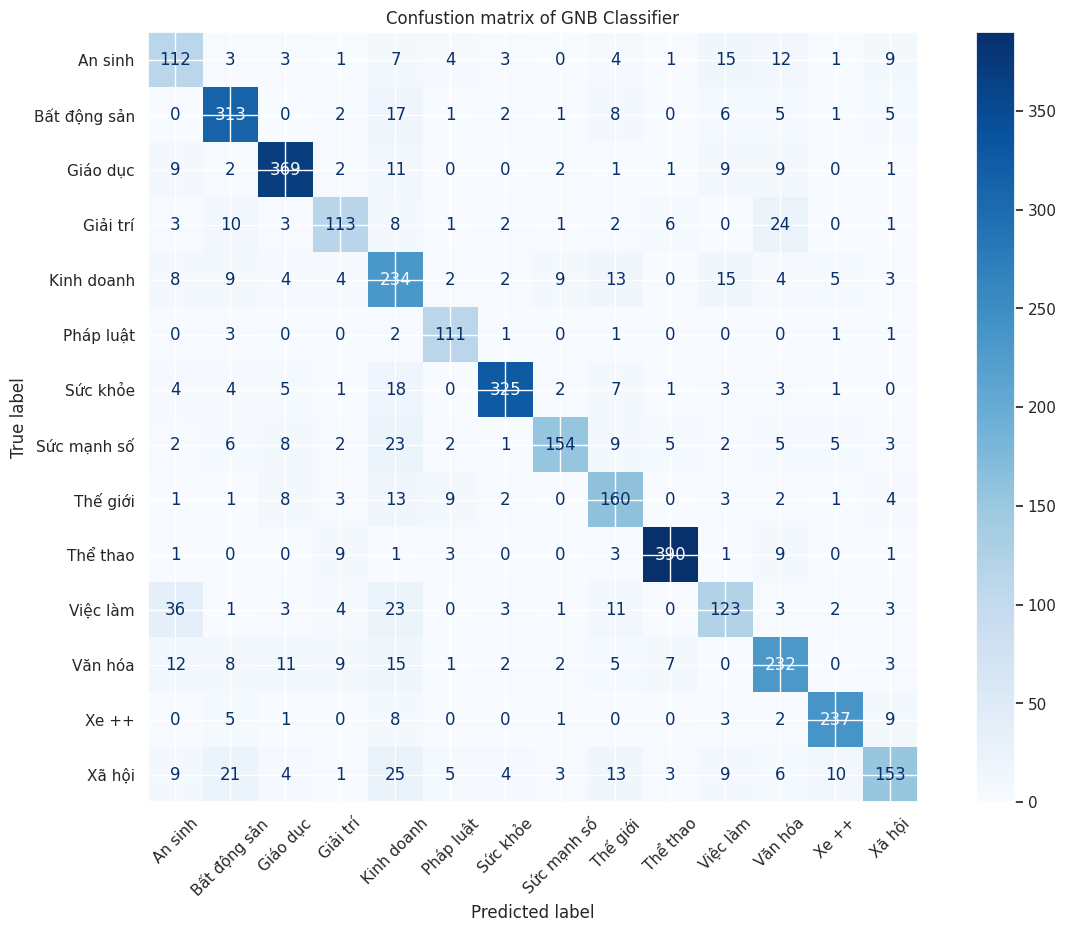

In [ ]:
gnb_disp = ConfusionMatrixDisplay.from_estimator(
      gnb_clf,
      X_test_cleaner_and_reduction_,
      y_test,
      display_labels=le.classes_,
      cmap=plt.cm.Blues,
)
gnb_disp.ax_.set_title("Confustion matrix of GNB Classifier")
gnb_disp.ax_.tick_params(axis='x', rotation=45)

print(gnb_disp.confusion_matrix)

In [ ]:
get_loss_in_each_category(gnb_disp.confusion_matrix)


,categories,num_of_true_categories,num_of_false_categories,total
0,An sinh,112,0.36,175
1,Bất động sản,313,0.13,361
2,Giáo dục,369,0.11,416
3,Giải trí,113,0.35,174
4,Kinh doanh,234,0.25,312
5,Pháp luật,111,0.08,120
6,Sức khỏe,325,0.13,374
7,Sức mạnh số,154,0.32,227
8,Thế giới,160,0.23,207
9,Thể thao,390,0.07,418


In [98]:
with open(os.path.join(MODEL_PATH, 'gnb_clf.pkl'), 'wb') as f:
  pickle.dump(gnb_clf, f)

with open(os.path.join(MODEL_PATH, 'gnb_cv.pkl'), 'wb') as f:
  pickle.dump(gnb_cv, f)

In [99]:
# Load results
with open(os.path.join(MODEL_PATH, 'gnb_clf.pkl'), 'rb') as f:
  gnb_clf = pickle.load(f)

with open(os.path.join(MODEL_PATH, 'gnb_cv.pkl'), 'rb') as f:
  gnb_cv = pickle.load(f)

In [ ]:
gnb_cv

{'fit_time': array([0.50008678, 0.37894511, 0.22548151, 0.27941775, 0.20188951]),
 'score_time': array([0.52389145, 0.5381217 , 0.44593024, 0.53379607, 0.26884007]),
 'test_score': array([0.74134078, 0.75977654, 0.76759777, 0.77541899, 0.77808832]),
 'train_score': array([0.81463892, 0.80751502, 0.81882945, 0.8129627 , 0.81201117])}

#### KNN

In [80]:
cv_params_knn = create_params_based_on_estimator(KNeighborsClassifier(n_neighbors=16, n_jobs=-1, weights='distance'),
                                                 X_train_cleaner_and_reduction_,
                                                 y_train,
                                                 cv=skf)

In [81]:
knn_cv = cross_validate(
    **cv_params_knn
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.8s finished


In [82]:
knn_clf, knn_acc, knn_time = train_model(cv_params_knn['estimator'], X_train_cleaner_and_reduction_,
                                         y_train, X_test_cleaner_and_reduction_,
                                         y_test)

Fit data completely ...
- Acc = 0.84436913451512
              precision    recall  f1-score   support

     An sinh       0.76      0.54      0.63       175
Bất động sản       0.90      0.87      0.88       361
    Giáo dục       0.92      0.89      0.90       416
    Giải trí       0.85      0.72      0.78       174
  Kinh doanh       0.87      0.82      0.84       312
   Pháp luật       0.82      0.92      0.87       120
    Sức khỏe       0.87      0.97      0.92       374
 Sức mạnh số       0.94      0.81      0.87       227
    Thế giới       0.87      0.74      0.80       207
    Thể thao       0.98      0.95      0.96       418
    Việc làm       0.59      0.80      0.68       213
     Văn hóa       0.69      0.91      0.78       307
       Xe ++       0.89      0.95      0.92       266
      Xã hội       0.81      0.65      0.72       266

    accuracy                           0.84      3836
   macro avg       0.84      0.82      0.83      3836
weighted avg       0.85      0.

[[ 95   0   4   1   3   1   7   1   1   0  41   8   2  11]
 [  1 313   0   0  13   1   2   0   1   1  14   7   3   5]
 [  4   0 371   3   1   0   5   2   1   0  11  17   0   1]
 [  0   3   3 125   2   0   3   1   0   1   4  31   0   1]
 [  1   8   1   4 255   2   7   4   5   0  13   8   2   2]
 [  0   4   0   0   0 110   1   1   1   0   1   0   0   2]
 [  2   0   3   0   1   0 363   0   1   0   2   2   0   0]
 [  0   2   4   0   7   4   4 183   2   1   1  12   5   2]
 [  1   0   5   1   5   7   7   0 154   0   7  15   2   3]
 [  0   0   0   5   0   4   2   0   1 396   1   9   0   0]
 [ 12   0   4   0   0   2   6   1   3   0 171   7   2   5]
 [  2   0   4   8   2   0   3   0   1   3   4 279   0   1]
 [  0   3   1   0   1   0   1   1   0   0   0   0 252   7]
 [  7  14   4   0   4   3   8   0   7   2  19  10  16 172]]


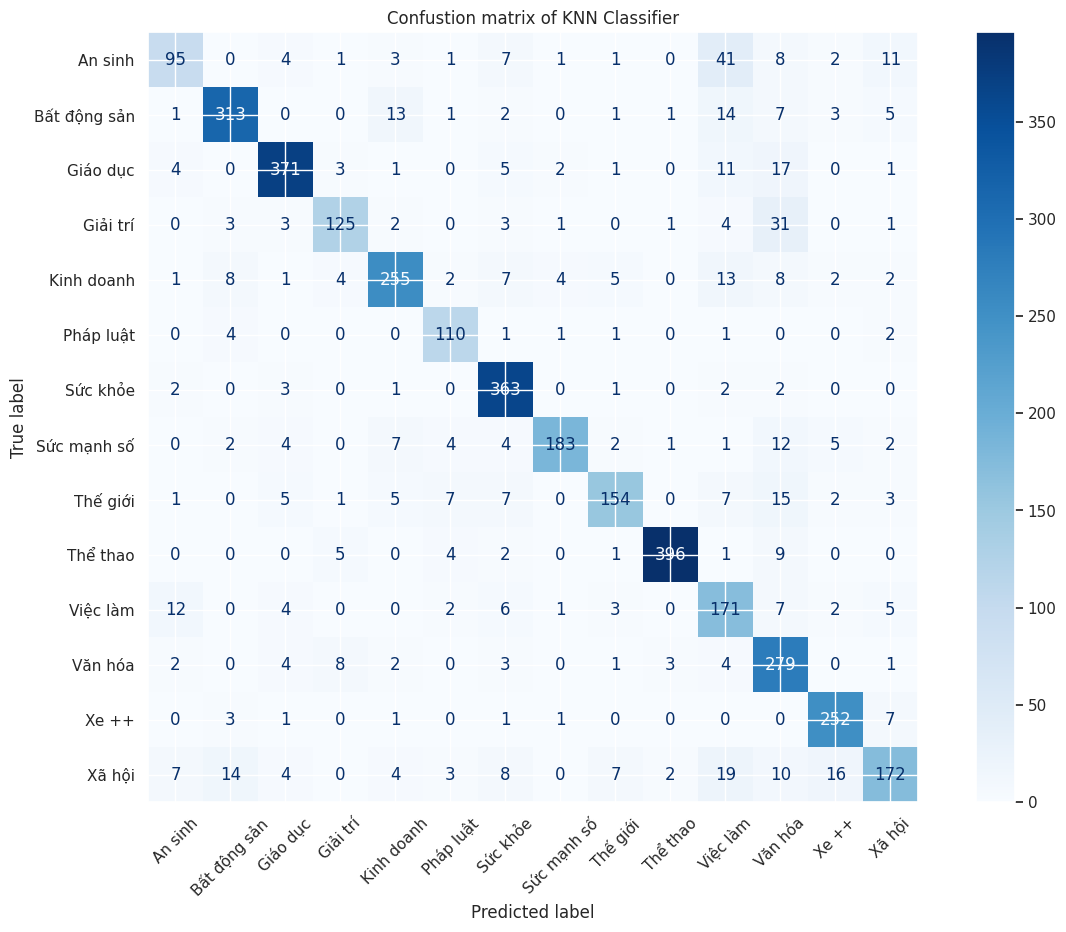

In [83]:
knn_disp = ConfusionMatrixDisplay.from_estimator(
      knn_clf,
      X_test_cleaner_and_reduction_,
      y_test,
      display_labels=le.classes_,
      cmap=plt.cm.Blues,
)
knn_disp.ax_.set_title("Confustion matrix of KNN Classifier")
knn_disp.ax_.tick_params(axis='x', rotation=45)

print(knn_disp.confusion_matrix)

In [84]:
get_loss_in_each_category(knn_disp.confusion_matrix)


,categories,num_of_true_categories,num_of_false_categories,total
0,An sinh,95,0.46,175
1,Bất động sản,313,0.13,361
2,Giáo dục,371,0.11,416
3,Giải trí,125,0.28,174
4,Kinh doanh,255,0.18,312
5,Pháp luật,110,0.08,120
6,Sức khỏe,363,0.03,374
7,Sức mạnh số,183,0.19,227
8,Thế giới,154,0.26,207
9,Thể thao,396,0.05,418


In [42]:
results = []
for k in range(1, 50):
  print(f"With k = {k}")
  clf = KNeighborsClassifier(n_neighbors=k, n_jobs=-1, weights='distance')
  clf.fit(X_train_cleaner_and_reduction_, y_train)
  y_pred = clf.predict(X_test_cleaner_and_reduction_)

  matrix_ = confusion_matrix(y_test, y_pred)
  df = get_loss_in_each_category(matrix_)
  results.append((k, np.mean(df['num_of_false_categories'])))

With k = 1
With k = 2
With k = 3
With k = 4
With k = 5
With k = 6
With k = 7
With k = 8
With k = 9
With k = 10
With k = 11
With k = 12
With k = 13
With k = 14
With k = 15
With k = 16
With k = 17
With k = 18
With k = 19
With k = 20
With k = 21
With k = 22
With k = 23
With k = 24
With k = 25
With k = 26
With k = 27
With k = 28
With k = 29
With k = 30
With k = 31
With k = 32
With k = 33
With k = 34
With k = 35
With k = 36
With k = 37
With k = 38
With k = 39
With k = 40
With k = 41
With k = 42
With k = 43
With k = 44
With k = 45
With k = 46
With k = 47
With k = 48
With k = 49


In [45]:
results = np.array(results)
k = results[:, 0]
loss = results[:, 1]

In [46]:
results_df = pd.DataFrame({
    'k': k,
    'loss': loss
})

results_df.head()

,k,loss
0,1.0,0.274286
1,2.0,0.274286
2,3.0,0.217857
3,4.0,0.203571
4,5.0,0.190714


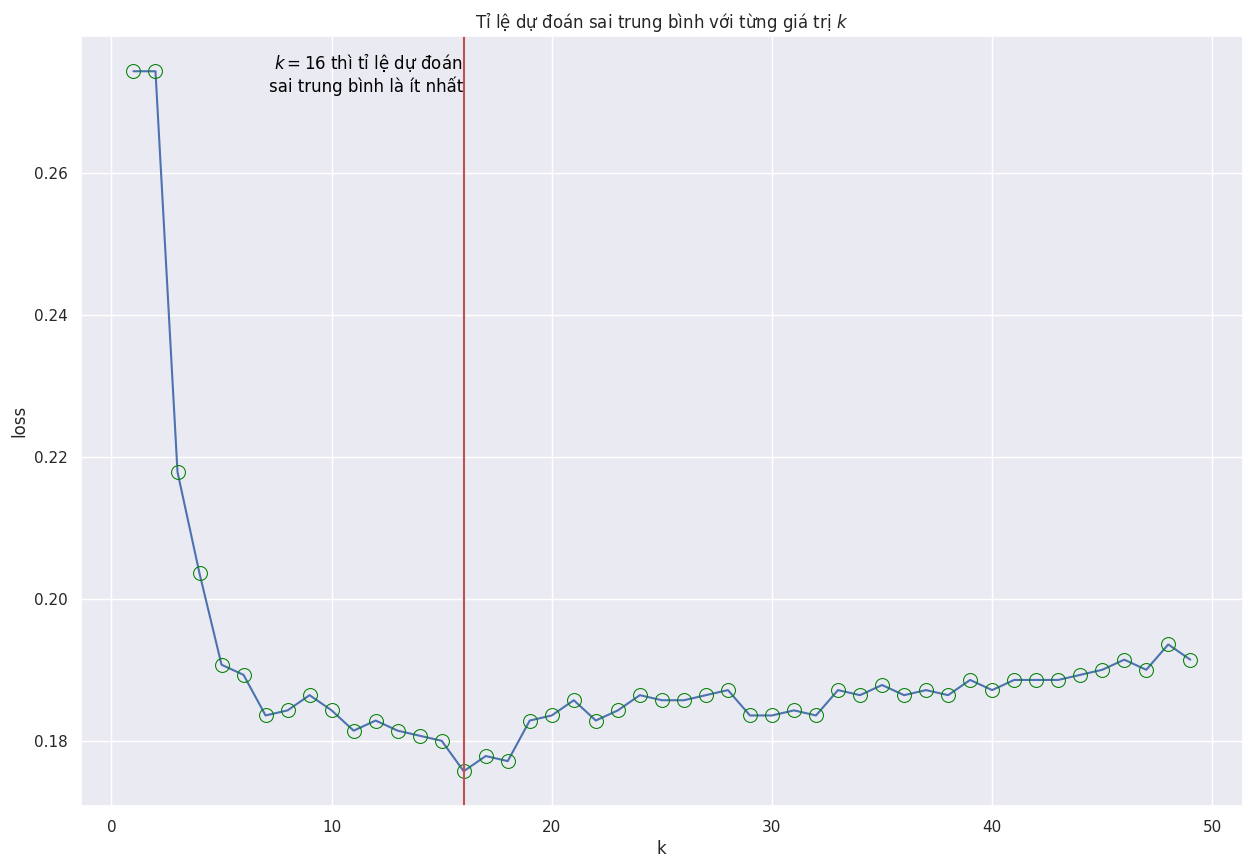

In [79]:
ax = sns.lineplot(data=results_df, x='k', y='loss', marker="o",
             markersize=10, markerfacecolor='red', fillstyle='none',
             markeredgecolor="green",)
plt.xlabel('k')
plt.ylabel('loss')
ax.axvline(16, color='r')
ax.text(16, 0.98, f"$k=16$ thì tỉ lệ dự đoán \nsai trung bình là ít nhất", color='black',
        ha='right', va='top', transform=ax.get_xaxis_transform())
plt.title('Tỉ lệ dự đoán sai trung bình với từng giá trị $k$')
plt.show()

In [ ]:
with open(os.path.join(MODEL_PATH, 'knn_clf.pkl'), 'wb') as f:
  pickle.dump(knn_clf, f)

with open(os.path.join(MODEL_PATH, 'knn_cv.pkl'), 'wb') as f:
  pickle.dump(knn_cv, f)

In [ ]:
# Load results
with open(os.path.join(MODEL_PATH, 'knn_clf.pkl'), 'rb') as f:
  knn_clf = pickle.load(f)

with open(os.path.join(MODEL_PATH, 'knn_cv.pkl'), 'rb') as f:
  knn_cv = pickle.load(f)

In [ ]:
knn_cv

{'fit_time': array([0.05297875, 0.0990963 , 0.04676151, 0.04183412, 0.04351068]),
 'score_time': array([3.17313266, 2.61071801, 1.7945025 , 1.76453161, 1.66693091]),
 'test_score': array([0.82234637, 0.8424581 , 0.85027933, 0.84581006, 0.84851873]),
 'train_score': array([1., 1., 1., 1., 1.])}

#### Decision Tree


In [ ]:
cv_params_dt = create_params_based_on_estimator(DecisionTreeClassifier(max_depth=20, random_state=RANDOM_STATE),
                                                 X_train_cleaner_and_reduction_,
                                                 y_train,
                                                 cv=skf)

In [ ]:
dt_cv = cross_validate(
    **cv_params_dt
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


In [ ]:
dt_clf, dt_acc, dt_time = train_model(cv_params_dt['estimator'], X_train_cleaner_and_reduction_,
                                         y_train, X_test_cleaner_and_reduction_,
                                         y_test)

Fit data completely ...
- Acc = 0.7403545359749739
              precision    recall  f1-score   support

     An sinh       0.45      0.42      0.44       175
Bất động sản       0.83      0.83      0.83       361
    Giáo dục       0.82      0.87      0.84       416
    Giải trí       0.71      0.63      0.67       174
  Kinh doanh       0.65      0.67      0.66       312
   Pháp luật       0.74      0.74      0.74       120
    Sức khỏe       0.93      0.90      0.92       374
 Sức mạnh số       0.73      0.63      0.68       227
    Thế giới       0.65      0.66      0.66       207
    Thể thao       0.88      0.88      0.88       418
    Việc làm       0.62      0.56      0.59       213
     Văn hóa       0.68      0.72      0.70       307
       Xe ++       0.86      0.79      0.82       266
      Xã hội       0.49      0.60      0.54       266

    accuracy                           0.74      3836
   macro avg       0.72      0.71      0.71      3836
weighted avg       0.74      

[[ 74   4  11   1   1   1   2   2   7   3  34   7   2  26]
 [  2 300   2   2  17   2   1   3   1   0   4   1   3  23]
 [  5   1 363   2   4   1   0   3  10   5   7  10   2   3]
 [  2   2   7 110   2   0   2   3   2   5   0  36   1   2]
 [  8   9   6   4 210   9   2  12   8   2  11   8   4  19]
 [  4   2   2   0   6  89   1   1   3   2   1   0   0   9]
 [  1   3   4   2   7   0 337   6   3   2   2   3   0   4]
 [  3   3   7   2  21   4   3 143   4   9   2  10   3  13]
 [  7   2  10   1  14   4   4   4 137   3   1   6   1  13]
 [  2   4   1   9   6   2   2   1   5 369   0   9   5   3]
 [ 30   7   8   3  15   1   1   3   3   3 119   6   1  13]
 [  7   4  15  19   7   2   4   4   6   5   2 220   1  11]
 [  1   3   2   0   6   1   1   7   2   5   3   0 210  25]
 [ 18  19   6   0   5   4   2   3  19   5   7   7  12 159]]


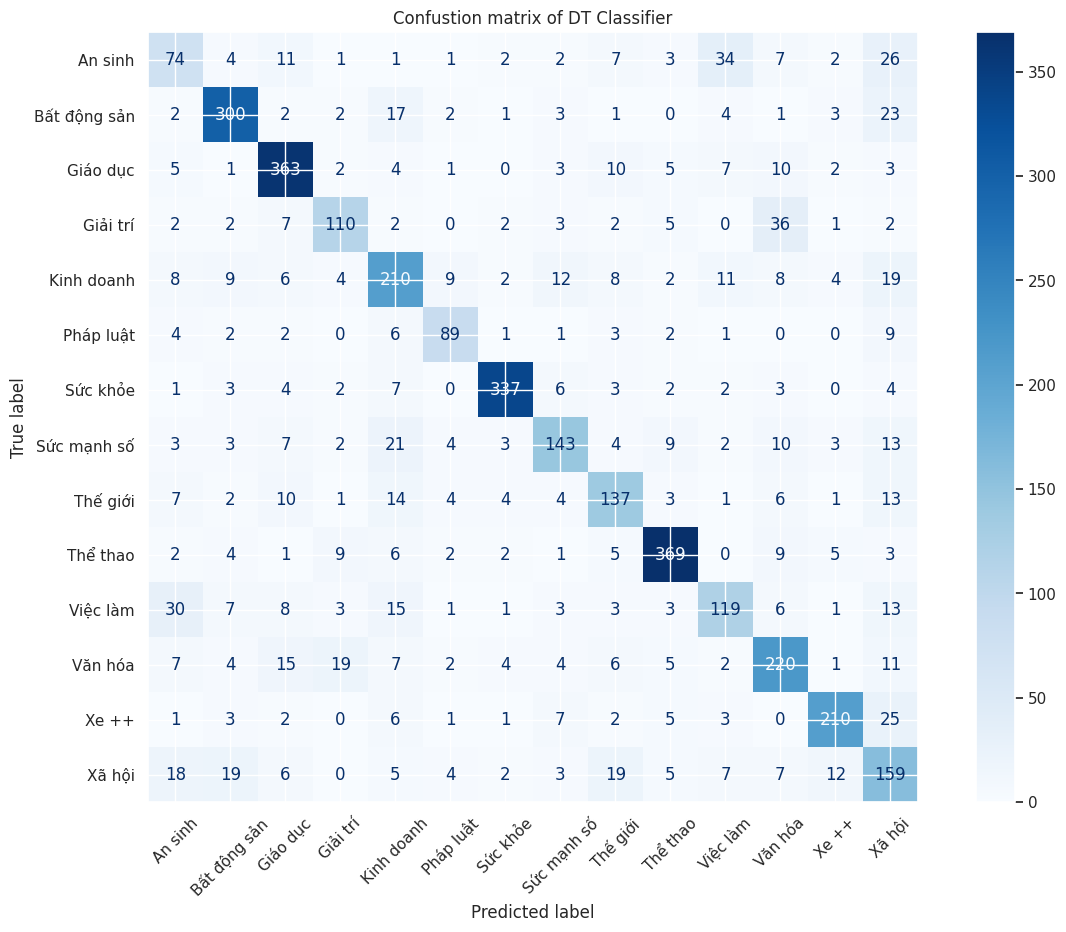

In [ ]:
dt_disp = ConfusionMatrixDisplay.from_estimator(
      dt_clf,
      X_test_cleaner_and_reduction_,
      y_test,
      display_labels=le.classes_,
      cmap=plt.cm.Blues,
)
dt_disp.ax_.set_title("Confustion matrix of DT Classifier")
dt_disp.ax_.tick_params(axis='x', rotation=45)

print(dt_disp.confusion_matrix)

In [ ]:
get_loss_in_each_category(dt_disp.confusion_matrix)


,categories,num_of_true_categories,num_of_false_categories,total
0,An sinh,74,0.58,175
1,Bất động sản,300,0.17,361
2,Giáo dục,363,0.13,416
3,Giải trí,110,0.37,174
4,Kinh doanh,210,0.33,312
5,Pháp luật,89,0.26,120
6,Sức khỏe,337,0.10,374
7,Sức mạnh số,143,0.37,227
8,Thế giới,137,0.34,207
9,Thể thao,369,0.12,418


In [ ]:
with open(os.path.join(MODEL_PATH, 'dt_clf.pkl'), 'wb') as f:
  pickle.dump(dt_clf, f)

with open(os.path.join(MODEL_PATH, 'dt_cv.pkl'), 'wb') as f:
  pickle.dump(dt_cv, f)

In [ ]:
# Load results
with open(os.path.join(MODEL_PATH, 'dt_clf.pkl'), 'rb') as f:
  dt_clf = pickle.load(f)

with open(os.path.join(MODEL_PATH, 'dt_cv.pkl'), 'rb') as f:
  dt_cv = pickle.load(f)

In [ ]:
dt_cv

{'fit_time': array([23.99919796, 23.61730361, 29.14699554, 29.11991501, 16.02168036]),
 'score_time': array([0.00747681, 0.01085019, 0.00615382, 0.00597453, 0.00436068]),
 'test_score': array([0.71843575, 0.69944134, 0.72011173, 0.71117318, 0.73672443]),
 'train_score': array([0.9857522 , 0.97024724, 0.95138986, 0.97024724, 0.98282123])}